# QAOA for MaxCut in PyQuil

The Quantum Approximate Optimzation Algorithm (QAOA) is a promising near-term hybrid algorithm. The [original Farhi paper on QAOA](https://arxiv.org/abs/1411.4028) demonstrated QAOA by using it to solve a MaxCut problem; here I will do the same, demonstrating its use on a random graph of 12 nodes

## What is this "hybrid" business?

We currently live in the NISQ-era of quantum computing: the "Noisy Intermiediate-Scale Quantum" technology era. The grandfather quantum algorithms like [Grover's](https://arxiv.org/abs/quant-ph/9605043) and [Shor's](https://arxiv.org/abs/quant-ph/9508027) provide quadratic/exponential speedups over their best known classical counterparts, but they require the use of Quantum Processing Units (QPUs) with large numbers of qubits, long coherence times, and a great deal of connectivity. Right now, we've got 50-150 qubits without much connectivity that are not robust to noise. If we want to squeeze out the most computing power possible from this current generation of smaller, noisy QPUs, we need to limit the number of operations we are performing on our qubits, i.e. __we want low-depth circuits__.

Hybrid algorithms shoot for this goal by using QPUs to perform a subroutine of a larger, classical optimzation algorithm. This quantum subroutine effectively amounts to preparing some initial quantum state using gates with some kind of parameterized dependence (angle of rotation of qubits on [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere), length of pulse acting on qubits, etc.) to approximate the ground state of a Hamiltonian that encodes whatever cost function we're trying to maximize (or minimize). By repeatedly performing measurements on this state, we can obtain an expectation value of the Hamiltonian of interest. We then use a classical optimizer to vary the gate parameters we use in our state preparation and feed these new values back to the quantum subroutine and obtain a new expectation value; rinse and repeat until we've maximized the cost Hamiltonian.

By exporting the parameter optimization to a classical optimizer and only using the QPU for state preparation and measurement, we can really limit the number of operations we'd have to carry out on our qubits, mitigating the risk of introducing error into our calculations.

## QAOA

QAOA aims to find a solution to an optimzation problem that meets some pre-determined threshold for the quality of a solution in polynomial time. That means that QAOA may not find the absolute _best_ solution to an optimization problem, but it will find solutions that approximate the best solution. The "polynomial time" specification here is important: the time to find the definite, absolute best solution may scale exponentially with the number of problem variables we've got, so QAOA (and other algorithms like it) is a trade-off between determinism and amount of time involved to solve a problem instance as the number of variables is scaled up.

To use QAOA, you need to do the following: encode the cost function of interest into a set of Pauli operators (a mathematical representation that a QPU can swallow), prepare an initial state to perform operations on, and then sample this prepared state to retrieve the ground state solution of the Hamiltonian that represents the cost function.

The iterative part comes from the fact that we vary gate parameters that operate on our qubits in order to produce the optimal ground state. These parameters are angles that we call _beta_ and _gamma_. Once we've found the optimal choice for _beta_ and _gamma_, we use these values in our parametrized gates that we apply to our quantum states, sample, and hopefully the giant superposition state we've created by applying the parameterized gates collapses to the ground state of the Hamiltonian that represents our cost function. 

## MaxCut

MaxCut is the prototypical example of the kind of problem that an algorithm like QAOA can be useful for. MaxCut falls under the blanket categorization of [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization), those problems where the goal is to find the optimal solution to some problem from a finite set of possible solutions. 

The aim of MaxCut is the following: Given a graph of nodes and edges, set the value of 0 or 1 to each node with the aim of maximizing the number of adjacent nodes with different values, i.e. minimize the number of "11" and "00" combos for nodes next to each other, and maximize the number of "01" and "10" combos of nodes next to each other.

## Sample problem: graph with 12 nodes

First, let's make some imports:

In [1]:
# pyQuil and Grove imports
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
from pyquil.api import QVMConnection

# useful additional packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Now, let's make a graph with 12 nodes:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


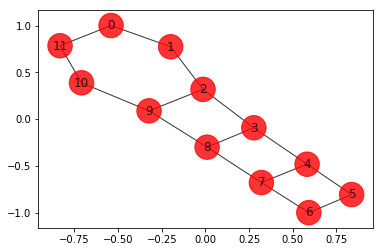

In [2]:
# Generating a graph of 12 nodes 

n = 12 # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(list(range(0, n, 1))) # creates a graph with the number of nodes we want

# tuple is (i, j, weight) where (i, j) is the edge
edge_list = [(0, 1, 1.0), (1, 2, 1.0), 
             (2, 3, 1.0), (3, 4, 1.0),
             (4, 5, 1.0), (5, 6, 1.0), 
             (6, 7, 1.0), (7, 8, 1.0), 
             (8, 9, 1.0), (9, 10, 1.0),
             (10, 11, 1.0), (0, 11, 1.0), 
             (2, 9, 1.0), (3, 8, 1.0), 
             (4, 7, 1.0)]

# above, we tell the graph how our nodes are connected. Below, we add these edges to the graph
G.add_weighted_edges_from(edge_list) 

# Let's draw this thing
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

Now, let's find the optimal assignment of 0's and 1's for each node using Rigetti's MaxCut QAOA module

__Note__: To use Rigetti's software, first we need to run the following commands on two separate Terminal windows:
`quilc -S`
and
`qvm -S`

These commands let us run quantum circuits on a [Quantum Virtual Machine](http://docs.rigetti.com/en/v2.5.2/qvm.html#qvm-use), and [compile/optimize](http://docs.rigetti.com/en/stable/compiler.html) our hardware-agnostic circuits for Rigetti's hardware.

In [3]:
# We initialize the maxcut_qaoa object with our graph, number of Trotterization steps,
# and number of samples to take (could specify many other parameters if we wanted to)
maxcut_solver = maxcut_qaoa(graph=G, steps = 1)

# I do not specify the number of samples because it would use VQE to obtain the ultimate beta and gamma
# values, and that can take a very long time. By not specifying the number of samples, QAOA instead uses 
# the "fast expectation method", i.e. finds the expectation value analytically (which is sort of cheating...)


# The QAOA algorithm tries to find the optimal values of betas and gammas.
# This line is where all the optimization takes place.
betas, gammas = maxcut_solver.get_angles()
print("Values of betas:", betas)
print("Values of gammas:", gammas)

                     models will be ineffective
	Parameters: [2.41174688 4.86189182] 
	E => -7.44710572107036
	Parameters: [2.41174688 4.86189182] 
	E => -7.497755919167808
	Parameters: [2.41174688 4.86189182] 
	E => -7.543578145162715
	Parameters: [2.46199161 5.0973897 ] 
	E => -8.170396248531397
	Parameters: [2.57324779 5.06320453] 
	E => -8.6198056924007
	Parameters: [2.72936533 5.51710771] 
	E => -10.609589199503393
	Parameters: [2.72936533 5.51710771] 
	E => -10.361749176164171
	Parameters: [2.72936533 5.51710771] 
	E => -10.092228894303371
	Parameters: [2.72936533 5.51710771] 
	E => -10.478074087944766
	Parameters: [2.72667365 5.64340295] 
	E => -10.412657791812828
	Parameters: [2.72667365 5.64340295] 
	E => -10.647379260184525
	Parameters: [2.74209474 5.56808873] 
	E => -10.666079108168608
	Parameters: [2.75867943 5.60024119] 
	E => -10.675037729757214
	Parameters: [2.75867943 5.60024119] 
	E => -10.674251361275804
	Parameters: [2.75867943 5.60024119] 
	E => -10.67502020652034
	

Now we reconstruct the program that gives us our beta, gamma states. Then we measure many times to obtain statistics

In [4]:
angles = np.hstack((betas, gammas))
param_prog = maxcut_solver.get_parameterized_program()
prog = param_prog(angles)
qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
qvm_connection = QVMConnection()
measurements = qvm_connection.run_and_measure(prog, qubits, trials=10000)

Now we can see which assignment of 0's and 1's was most common. Hopefully they are the ones that actually correspond to a maximization of our initial cost function, i.e. maximizing the number of adjacent nodes with opposite value!

In [5]:
from collections import Counter
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
measurements_counter.most_common()

[((0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1), 262),
 ((1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0), 205),
 ((1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0), 127),
 ((0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1), 118),
 ((1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0), 108),
 ((0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1), 99),
 ((0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1), 95),
 ((0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1), 76),
 ((1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0), 73),
 ((0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1), 67),
 ((1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0), 67),
 ((1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1), 65),
 ((1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0), 63),
 ((1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1), 60),
 ((0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0), 60),
 ((0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), 58),
 ((0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0), 56),
 ((1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0), 55),
 ((0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1), 50),
 ((0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1), 49),
 ((0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1), 45),
 ((1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0), 43),
 ((1,